In [1]:
import pandas as pd
import numpy as np
import math
import warnings
warnings.filterwarnings("ignore")
import datetime as dt
import time
from datetime import datetime
from sodapy import Socrata
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.preprocessing.sequence import TimeseriesGenerator

Using TensorFlow backend.


# Investigate overall data

In [2]:
# Import data from API

client = Socrata('data.melbourne.vic.gov.au',
                 'rU9dviaJKpt9U9Mk9aPFFOIvS',
                 'khairul@yahoo.com',
                 'KhairulMaps2019&')

# To begin, download all data but limit to only for monday noons for overview
results = client.get("b2ak-trbp", day='Monday', time=12, limit=50000)

dfraw0 = pd.DataFrame.from_records(results)
display(len(dfraw0))
display(dfraw0.head())

17822

,date_time,day,hourly_counts,id,mdate,month,sensor_id,sensor_name,time,year
0,2019-11-04T12:00:00.000,Monday,4535,2891212,4,November,4,Town Hall (West),12,2019
1,2019-11-04T12:00:00.000,Monday,1145,2891213,4,November,17,Collins Place (South),12,2019
2,2019-11-04T12:00:00.000,Monday,421,2891214,4,November,18,Collins Place (North),12,2019
3,2019-11-04T12:00:00.000,Monday,2570,2891215,4,November,53,Collins St (North),12,2019
4,2019-11-04T12:00:00.000,Monday,5227,2891216,4,November,2,Bourke Street Mall (South),12,2019


In [3]:
# First round of cleaning
df = dfraw0.copy()
df['date_time'] = pd.to_datetime(df['date_time'])
df['date'] = df['date_time'].dt.date
df['year'] = df['year'].astype('int')
df['hourly_counts'] = df['hourly_counts'].astype('int')
df['sensor'] = df['sensor_id'].map(lambda row: '0'+str(row) if int(row)<10 else row) + " : " + df['sensor_name']
df['sensor_id'] = df['sensor_id'].astype('int')
df.dtypes

date_time        datetime64[ns]
day                      object
hourly_counts             int64
id                       object
mdate                    object
month                    object
sensor_id                 int64
sensor_name              object
time                     object
year                      int64
date                     object
sensor                   object
dtype: object

In [4]:
# Convert to pivot for plotting
table = pd.pivot_table(df, values='hourly_counts', index='date',
                       columns='sensor', aggfunc=np.sum)
table.head(2)

sensor,01 : Bourke Street Mall (North),02 : Bourke Street Mall (South),03 : Melbourne Central,04 : Town Hall (West),05 : Princes Bridge,06 : Flinders Street Station Underpass,07 : Birrarung Marr,08 : Webb Bridge,09 : Southern Cross Station,10 : Victoria Point,...,56 : Lonsdale St - Elizabeth St (North),57 : Bourke St Bridge,58 : Bourke St - Spencer St (North),59 : Swanston St - RMIT Building 80,60 : Flinders La - Swanston St (West) Temp,60 : Flinders la - Swanston St (West) Temp,61 : Swanston St - RMIT Building 14,62 : La Trobe St (North),63 : 231 Bourke St,64 : Royal Pde-Grattan St
date,,,,,,,,,,,,,,,,,,,,,
2009-05-04,3532.0,2761.0,NaN,3789.0,1492.0,1931.0,NaN,NaN,808.0,529.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-05-11,3246.0,2483.0,NaN,3434.0,1269.0,1874.0,NaN,NaN,752.0,477.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


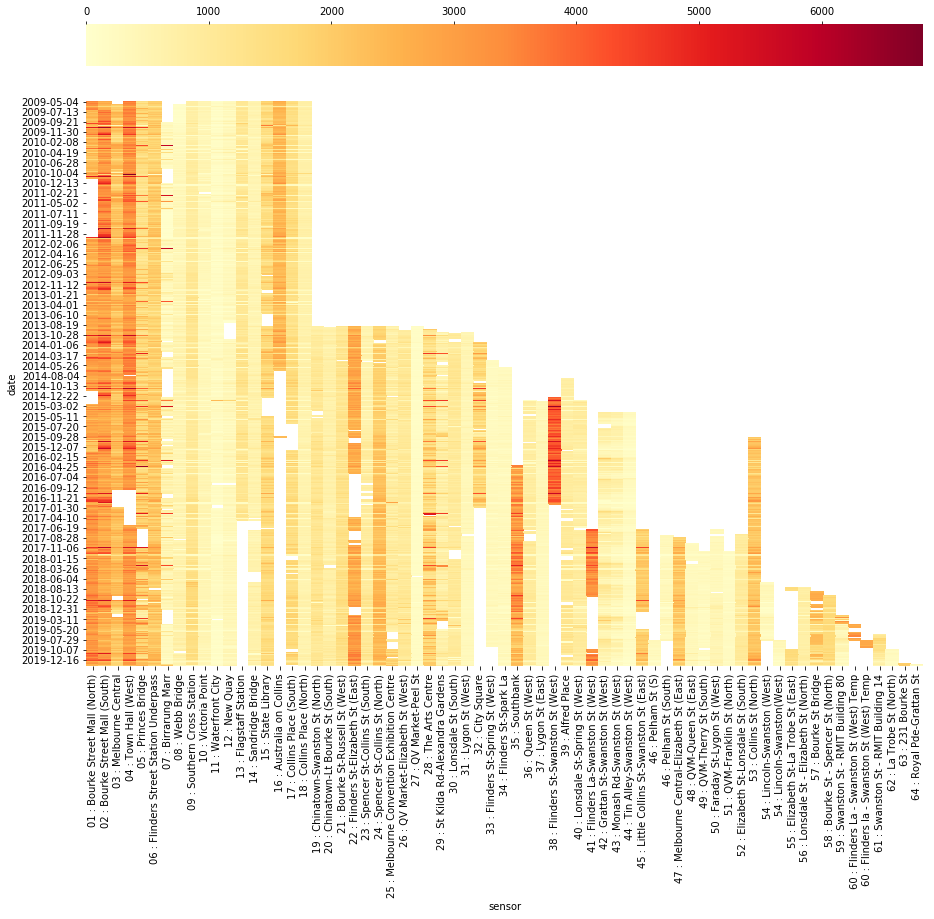

In [5]:
# Plot all available data, sampling at Monday noon only
fig, ax = plt.subplots(figsize=(15,13))
ax = sns.heatmap(table, cbar_kws = dict(use_gridspec=False,location="top"), cmap='YlOrRd')
plt.show()

# Shortlist sensor locations and period

In [6]:
# Group sensor locations based on availability of data

sensor_master = pd.read_excel('files/CBD_grid.xlsx', sheet_name='master')
sensor_master = sensor_master.iloc[:,:8]
sensor_master.head()

,sensor_id,sensor_description,installation_date,CBD,Train_data,Test_data,x,y
0,1,Bourke Street Mall (North),2009-03-24,1,1,1,NaN,NaN
1,2,Bourke Street Mall (South),2009-03-30,1,1,1,NaN,NaN
2,3,Melbourne Central,2009-03-25,1,1,1,NaN,NaN
3,4,Town Hall (West),2009-03-23,1,1,1,NaN,NaN
4,5,Princes Bridge,2009-03-26,1,1,1,NaN,NaN


In [7]:
# List of sensor for training and test data
sensors = list(sensor_master[sensor_master['CBD']==1].sensor_id)
sensors_train_test = list(sensor_master[sensor_master['Train_data']==1].sensor_id)
sensors_test = list(sensor_master[(sensor_master['Train_data']==0)&sensor_master['Test_data']==1].sensor_id)
len(sensors)

39

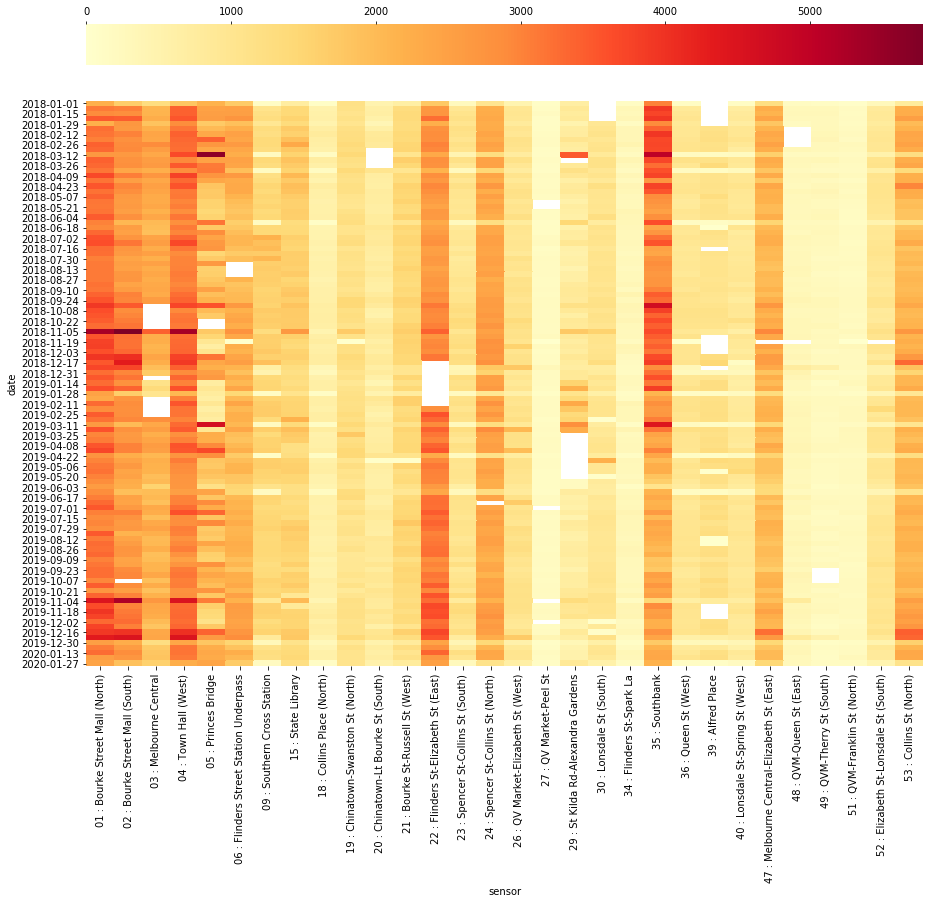

In [8]:
# Visualize training+test sensors for past 2 years
dftt = df[df['sensor_id'].isin(sensors_train_test)]
dfplot2 = dftt[dftt['year'] >= 2018][['date','sensor','hourly_counts']]

table2 = pd.pivot_table(dfplot2, values='hourly_counts', index='date',
                       columns='sensor', aggfunc=np.sum)

fig, ax = plt.subplots(figsize=(15,13))
ax = sns.heatmap(table2, cbar_kws = dict(use_gridspec=False,location="top"), cmap='YlOrRd')
plt.show()

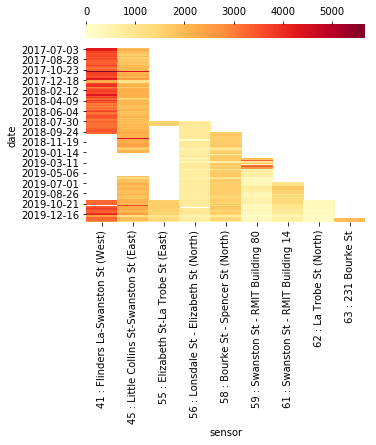

In [9]:
# Visualize test sensors only
dfts = df[df['sensor_id'].isin(sensors_test)]
table3 = pd.pivot_table(dfts, values='hourly_counts', index='date',
                       columns='sensor', aggfunc=np.sum)

fig, ax = plt.subplots(figsize=(5,4))
ax = sns.heatmap(table3, cbar_kws = dict(use_gridspec=False,location="top"), cmap='YlOrRd')
plt.show()

In [10]:
# Download all data for shortlisted sensor for last 2 years

# pbar  = progressbar.ProgressBar()
# dfraw = pd.DataFrame(columns=dfraw0.columns)
# years = [2018, 2019, 2020]

# for year in years:
#     for sensor in sensors:
#         results = client.get("b2ak-trbp", sensor_id=sensor, year=year, limit=10000)
#         dfitem = pd.DataFrame.from_records(results)
#         dfraw = pd.concat([dfraw, dfitem])
# dfraw.to_csv('files/sensors_data.csv')
# len(dfraw)

In [11]:
# Open from saved API
dfraw = pd.read_csv('files/sensors_data.csv')
dfraw = dfraw.drop('Unnamed: 0', axis=1)

In [12]:
# Check if no missing datastamps 
a = len(dfraw.date_time.unique())
b = 2*365*24 + 31*24 # num of hours from 01-01-2018 to 31-01-2020
c = sorted(dfraw.date_time.unique())[-1]
print('Latest available timestamp in data: {c}'.format(c=c))
print('Number of unique timestamps in data: {a}'.format(a=a))
print('Number of expected timestamps: {b}'.format(b=b))
print('Missing timestamps: {d}'.format(d=b-a))

Latest available timestamp in data: 2020-01-31T23:00:00.000
Number of unique timestamps in data: 18264
Number of expected timestamps: 18264
Missing timestamps: 0


# Deal with missing (null) records

In [13]:
# Reshape df into pivot for filling nulls
df0 = dfraw[dfraw['sensor_id'].isin(sensors_train_test)] # exclude test-only sites
df0 = pd.pivot_table(df0, columns='sensor_id',
                     values='hourly_counts',
                     index=['date_time'],
                     aggfunc=np.sum)
display(df0.shape)
display(df0.head(3))

(18264, 30)

sensor_id,1,2,3,4,5,6,9,15,18,19,...,35,36,39,40,47,48,49,51,52,53
date_time,,,,,,,,,,,,,,,,,,,,,
2018-01-01T00:00:00.000,895.0,734.0,2996.0,3052.0,1757.0,3443.0,1411.0,1709.0,326.0,605.0,...,5724.0,685.0,NaN,607.0,1542.0,223.0,264.0,390.0,493.0,1129.0
2018-01-01T01:00:00.000,890.0,590.0,3481.0,3204.0,3900.0,3579.0,436.0,1511.0,118.0,813.0,...,5168.0,604.0,NaN,110.0,1227.0,201.0,215.0,134.0,541.0,626.0
2018-01-01T02:00:00.000,435.0,317.0,1721.0,2042.0,2012.0,3157.0,222.0,666.0,64.0,473.0,...,2495.0,309.0,NaN,65.0,684.0,87.0,116.0,83.0,373.0,226.0


In [14]:
# Check the extent of nan values.
# Total records per sensor_id = 18,284
df0.isna().sum()

sensor_id
1      144
2      240
3     1570
4        0
5      264
6      433
9        0
15       0
18       0
19       0
20     792
21       0
22    1512
23       0
24      72
26      48
27     672
29    1634
30     600
34       0
35       0
36       0
39    2286
40       0
47     108
48     708
49     408
51       0
52     121
53       0
dtype: int64

In [15]:
# Since hourly traffic is very cyclical, copy value from
# the same time and the same day a week ago.

# Number of hours in a week
week_hrs = 7*24

for site in df0.columns:
    for row in range(len(df0.index)):
      # check if hourly record is null
        if math.isnan(df0[site].iloc[row]):
          # if so, copy from the same hour from a week ago
            if row - week_hrs > 0:
                df0[site].iloc[row] = df0[site].iloc[row - week_hrs]
            else:
                # if missing at start of the record:
                df0[site].iloc[row] = df0[site].iloc[row + week_hrs*6]

In [16]:
# Double check no nulls left
(df0.isna().sum()).sum()

0

In [17]:
# Unstack pivot to double check and prepare to build other columns

df0 = pd.DataFrame(df0.stack())
df0 = df0.rename(columns={0:'hourly_counts'})
df0 = df0.reset_index()
print('Number of complete timestamps: {b}'.format(b=b))
print('Number of df rows: {l1}'.format(l1=len(df0)))
print('Number df rows / timestamps = num of sites: {l2}'.format(l2=len(df0)/b))
display(df0.head())

Number of complete timestamps: 18264
Number of df rows: 547920
Number df rows / timestamps = num of sites: 30.0


,date_time,sensor_id,hourly_counts
0,2018-01-01T00:00:00.000,1,895.0
1,2018-01-01T00:00:00.000,2,734.0
2,2018-01-01T00:00:00.000,3,2996.0
3,2018-01-01T00:00:00.000,4,3052.0
4,2018-01-01T00:00:00.000,5,1757.0


In [18]:
# Build complete data frame
df = df0.copy()
df['date_time'] = pd.to_datetime(df['date_time']) # format='%Y-%m-%d %H:%M:%S'
df['time']      = df['date_time'].dt.hour
df['mdate']     = df['date_time'].dt.day
df['day']       = df['date_time'].dt.dayofweek
df['week']      = df['date_time'].dt.weekofyear
df['month']     = df['date_time'].dt.month
df['year']      = df['date_time'].dt.year
df['hourly_counts'] = df['hourly_counts'].astype('int')

names_table = sensor_master[['sensor_id', 'sensor_description']].set_index('sensor_id')
names_table = names_table.rename(columns={'sensor_description':'sensor_name'})
df = df.join(names_table, on='sensor_id')
df['sensor'] = (df['sensor_id'].map(lambda row: '0'+str(row)\
                                    if int(row)<10 else row)).astype('str')\
                                     + " : " + df['sensor_name']
display(len(df))
display(sorted(df.date_time.unique())[-1])
display(df.head(3))
display(df.dtypes)

547920

numpy.datetime64('2020-01-31T23:00:00.000000000')

,date_time,sensor_id,hourly_counts,time,mdate,day,week,month,year,sensor_name,sensor
0,2018-01-01,1,895,0,1,0,1,1,2018,Bourke Street Mall (North),01 : Bourke Street Mall (North)
1,2018-01-01,2,734,0,1,0,1,1,2018,Bourke Street Mall (South),02 : Bourke Street Mall (South)
2,2018-01-01,3,2996,0,1,0,1,1,2018,Melbourne Central,03 : Melbourne Central


date_time        datetime64[ns]
sensor_id                 int64
hourly_counts             int64
time                      int64
mdate                     int64
day                       int64
week                      int64
month                     int64
year                      int64
sensor_name              object
sensor                   object
dtype: object

# Investigate variations by location

## 1. Variation by traffic volume

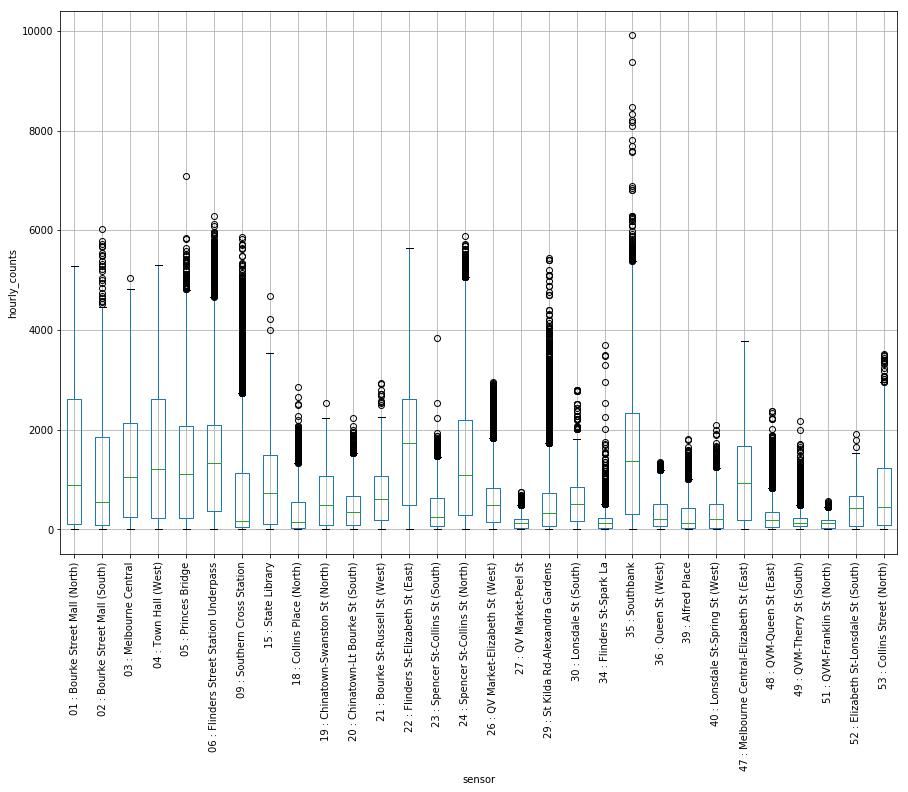

In [19]:
pivotvolume = pd.pivot_table(df, values='hourly_counts',
                             index='date_time', columns='sensor',
                             aggfunc=np.mean)
fig, ax = plt.subplots(figsize=(15,10))
pivotvolume.boxplot(ax=ax)
plt.xticks(rotation=90)
ax.set_xlabel('sensor')
ax.set_ylabel('hourly_counts')
plt.show()

### 2. Variation by hour

In [20]:
# Prepare data for hourly variation
weekdays = df[df['day'] < 5]
weekends = df[df['day'] > 4]

# Part 1
# Normalize data for each sensor
# Weekdays:
pivothour = pd.pivot_table(weekdays, values='hourly_counts',
                           index='time', columns='sensor_id',
                           aggfunc=np.nanmean)
hourcols = pivothour.columns
pivothour = preprocessing.normalize(pivothour, norm='l1', axis=0)
dfhour = pd.DataFrame(pivothour, index=range(0,24), columns=hourcols)
# Weekends:
pivothourW = pd.pivot_table(weekends, values='hourly_counts',
                           index='time', columns='sensor_id',
                           aggfunc=np.nanmean)
hourcolsW = pivothourW.columns
pivothourW = preprocessing.normalize(pivothourW, norm='l1', axis=0)
dfhourW = pd.DataFrame(pivothourW, index=range(0,24), columns=hourcols)

# Part 2
# Normalize data for avg of all sensors
# Weekdays:
pivothour2 = pd.pivot_table(weekdays, values='hourly_counts',
                            index='time', aggfunc=np.nanmean)
dfhour2 = preprocessing.normalize(pivothour2, norm='l1', axis=0)
dfhour2 = pd.DataFrame(dfhour2, index=range(0,24), columns=['all_sensors'])
# Weekends:
pivothour2W = pd.pivot_table(weekends, values='hourly_counts',
                            index='time', aggfunc=np.nanmean)
dfhour2W = preprocessing.normalize(pivothour2W, norm='l1', axis=0)
dfhour2W = pd.DataFrame(dfhour2W, index=range(0,24), columns=['all_sensors'])
# Each of the 7 days
pivothour2E = pd.pivot_table(df, values='hourly_counts', columns='day',
                            index='time', aggfunc=np.nanmean)
dfhour2E = preprocessing.normalize(pivothour2E, norm='l1', axis=0)
dfhour2E = pd.DataFrame(dfhour2E, index=range(0,24), columns=range(0,7))

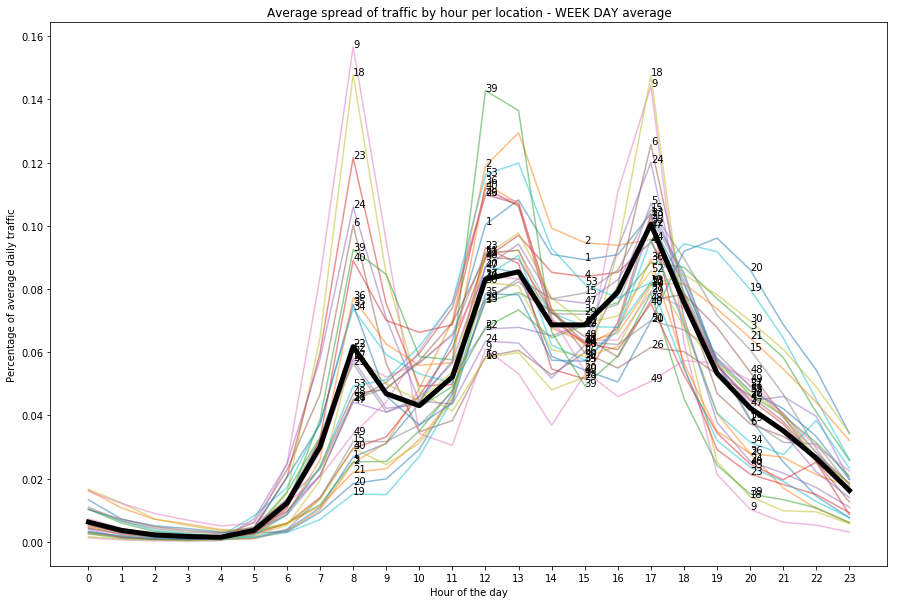

In [21]:
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(dfhour, alpha=0.5)
ax.plot(dfhour2, linewidth=5, c='black')

for hour in [8,12,15,17,20]:
    labels = zip(dfhour[dfhour.index == hour].values[0], dfhour.columns)
    for y, label in labels:
        plt.text(hour, y, label, fontsize=10)

ax.set_title('Average spread of traffic by hour per location - WEEK DAY average')
ax.set_ylabel('Percentage of average daily traffic')
ax.set_xlabel('Hour of the day')
ax.set_xticks(range(0,24))
plt.show()

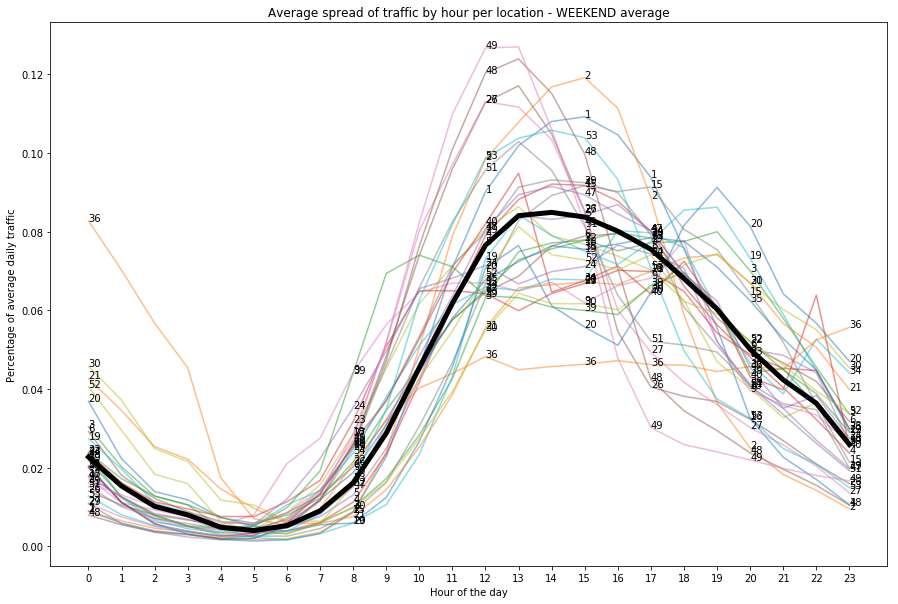

In [22]:
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(dfhourW, alpha=0.5)
ax.plot(dfhour2W, linewidth=5, c='black')

for hour in [0,8,12,15,17,20,23]:
    labels = zip(dfhourW[dfhourW.index == hour].values[0], dfhourW.columns)
    for y, label in labels:
        plt.text(hour, y, label, fontsize=10)

ax.set_title('Average spread of traffic by hour per location - WEEKEND average')
ax.set_ylabel('Percentage of average daily traffic')
ax.set_xlabel('Hour of the day')
ax.set_xticks(range(0,24))
plt.show()

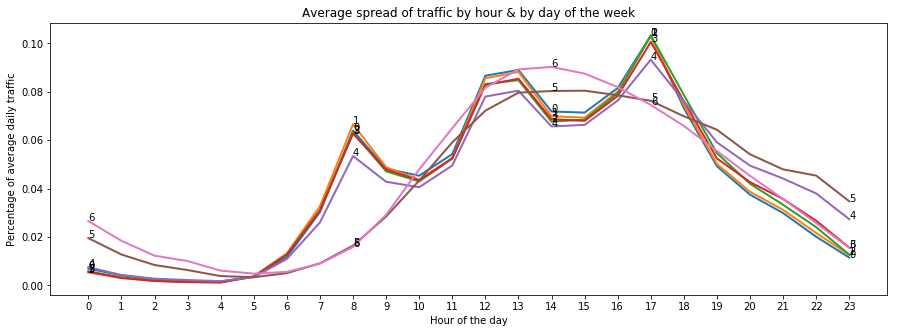

In [23]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(dfhour2E, linewidth=2)

for hour in [0,8,14,17,23]:
    labels = zip(dfhour2E[dfhour2E.index == hour].values[0], dfhour2E.columns)
    for y, label in labels:
        plt.text(hour, y, label, fontsize=10)

ax.set_title('Average spread of traffic by hour & by day of the week')
ax.set_ylabel('Percentage of average daily traffic')
ax.set_xlabel('Hour of the day')
ax.set_xticks(range(0,24))
plt.show()

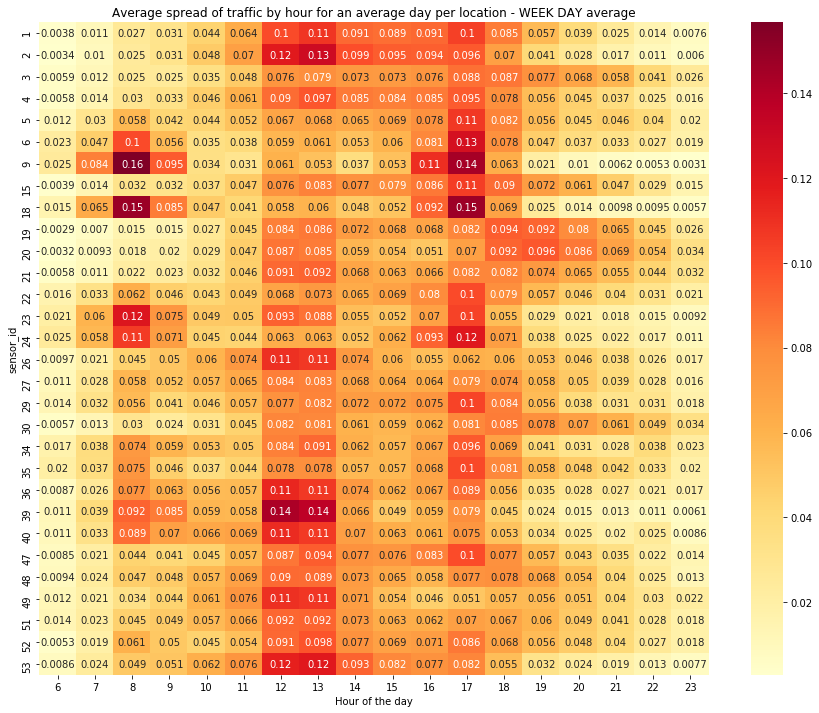

In [24]:
fig, ax = plt.subplots(figsize=(15,12))
sns.heatmap(dfhour[dfhour.index > 5].T, ax=ax, cmap='YlOrRd', annot=True)
ax.set_title('Average spread of traffic by hour for an average day per location - WEEK DAY average')
ax.set_xlabel('Hour of the day')
plt.show()

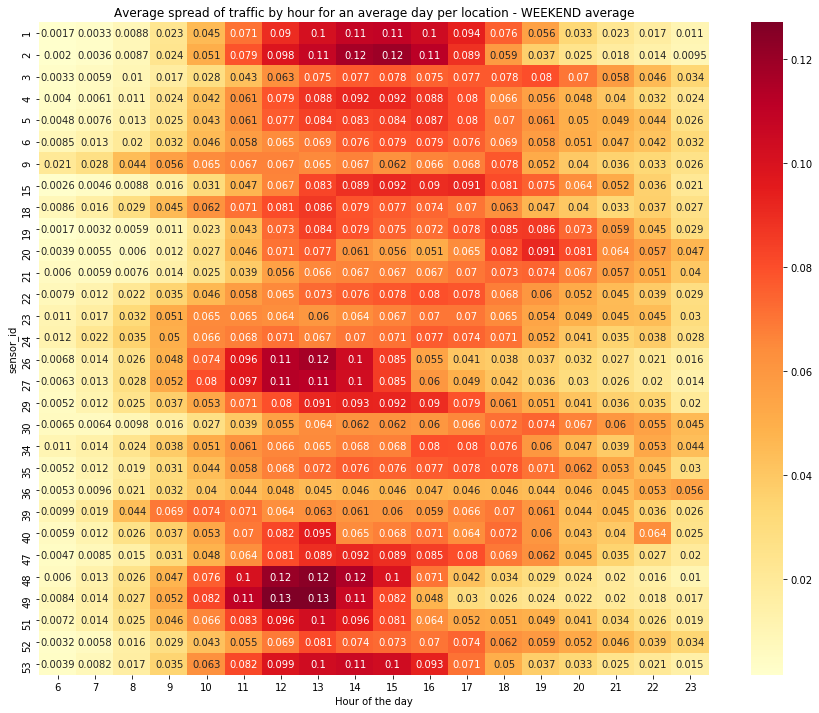

In [25]:
fig, ax = plt.subplots(figsize=(15,12))
sns.heatmap(dfhourW[dfhourW.index > 5].T, ax=ax, cmap='YlOrRd', annot=True)
ax.set_title('Average spread of traffic by hour for an average day per location - WEEKEND average')
ax.set_xlabel('Hour of the day')
plt.show()

#### 3. Variation by week day

In [26]:
# Normalize data for each sensor
pivotweek = pd.pivot_table(df, values='hourly_counts',
                           index='day', columns='sensor_id',
                           aggfunc=np.nanmean)
weekcols = pivotweek.columns
pivotweek = preprocessing.normalize(pivotweek, norm='l1', axis=0)
dfweek = pd.DataFrame(pivotweek, index=range(0,7), columns=weekcols)

# Normalize data for avg of all sensors
pivotweek2 = pd.pivot_table(df, values='hourly_counts',
                            index='day', aggfunc=np.nanmean)
dfweek2 = preprocessing.normalize(pivotweek2, norm='l1', axis=0)
dfweek2 = pd.DataFrame(dfweek2, index=range(0,7), columns=['all_sensors'])

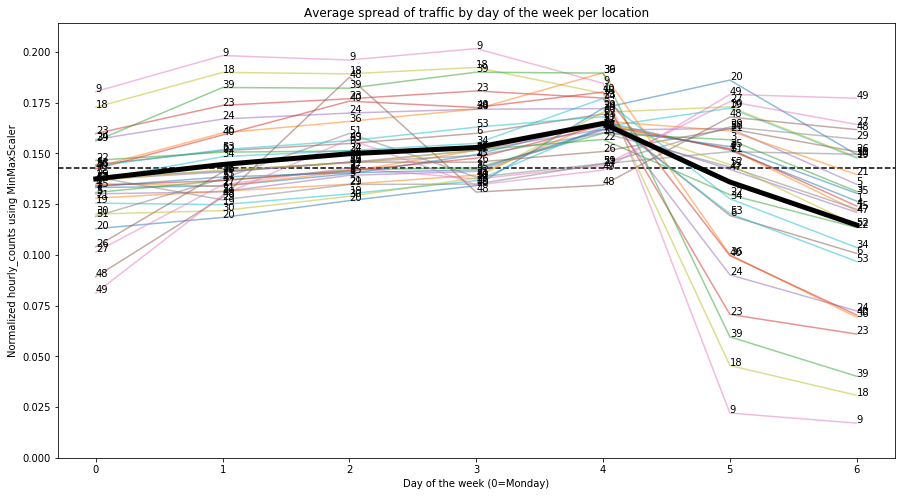

In [27]:
fig, ax = plt.subplots(figsize=(15,8))

ax.hlines(1/7,-0.3,6.3,linestyles='dashed') # if equal spread
ax.plot(dfweek, alpha=0.5) # actual spread
ax.plot(dfweek2, linewidth=5, c='black')

for day in range(0,7):
    labels = zip(dfweek[dfweek.index == day].values[0], dfweek.columns)
    for y, label in labels:
        plt.text(day, y, label, fontsize=10)

ax.set_title('Average spread of traffic by day of the week per location')
ax.set_ylabel('Normalized hourly_counts using MinMaxScaler')
ax.set_ylim(0,1.5/7)
ax.set_xlim(-0.3,6.3)
ax.set_xlabel('Day of the week (0=Monday)')
plt.show()

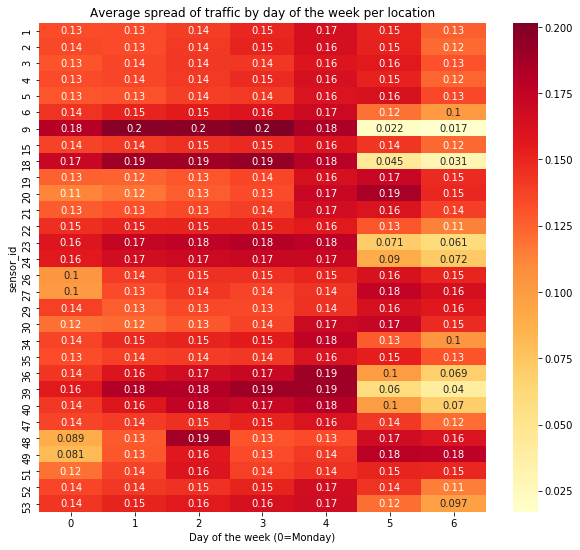

In [28]:
fig, ax = plt.subplots(figsize=(10,9))
sns.heatmap(dfweek.T, ax=ax, cmap='YlOrRd', annot=True)
ax.set_title('Average spread of traffic by day of the week per location')
ax.set_xlabel('Day of the week (0=Monday)')
plt.show()

### 4. Seasonal variation

In [29]:
# Normalize data by sensor
pivotseason = pd.pivot_table(df, values='hourly_counts',
                             index='week', columns='sensor_id',
                             aggfunc=np.nanmean)

nullcols = list((pivotseason.loc[:, pivotseason.isnull().any()]).columns)
dfseason = pivotseason = pivotseason.loc[:, pivotseason.columns.difference(nullcols)]
seasoncols = dfseason.columns
dfseason = preprocessing.normalize(dfseason, norm='l1', axis=0)
dfseason = pd.DataFrame(dfseason, index=range(0,52), columns=seasoncols)

# Normalize data for avg of all sensors
pivotseason2 = pd.pivot_table(df, values='hourly_counts',
                             index='week', aggfunc=np.nanmean)
dfseason2 = preprocessing.normalize(pivotseason2, norm='l1', axis=0)
dfseason2 = pd.DataFrame(dfseason2, index=range(0,52), columns=['all_sensors'])

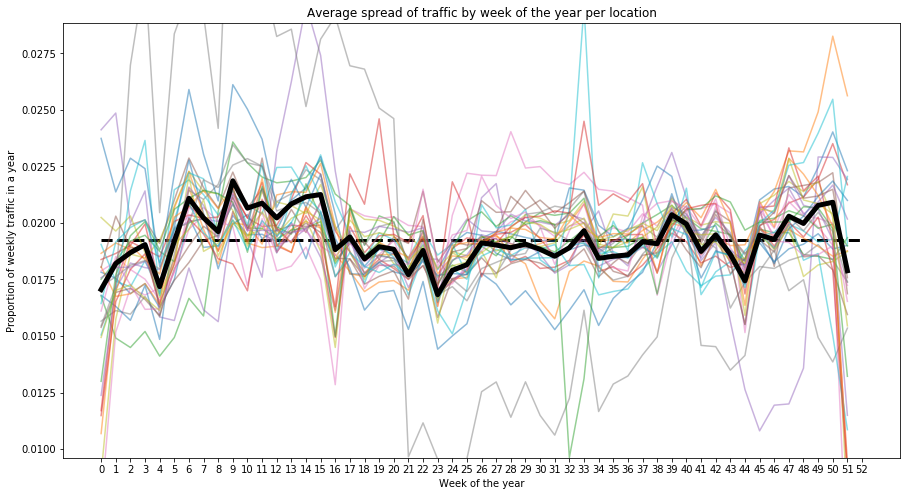

In [30]:
fig, ax = plt.subplots(figsize=(15,8))

ax.hlines(1/52,0,52,linestyles='dashed', linewidth=3) # if equal spread
ax.plot(dfseason, alpha=0.5)
ax.plot(dfseason2, linewidth=5, c='black')

ax.set_title('Average spread of traffic by week of the year per location')
ax.set_ylim(0.5/52,1.5/52)
ax.set_ylabel('Proportion of weekly traffic in a year')
ax.set_xlabel('Week of the year')
ax.set_xticks(range(0,53))
plt.show()

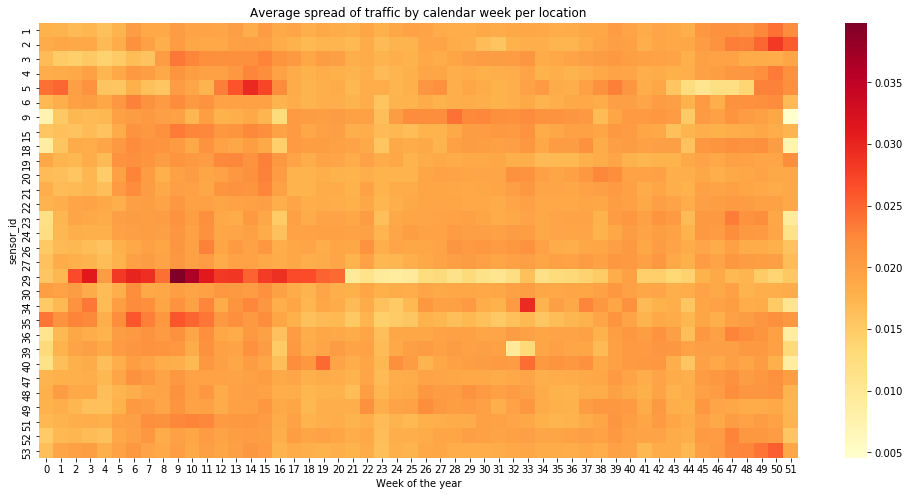

In [31]:
fig, ax = plt.subplots(figsize=(17,8))
sns.heatmap(dfseason.T, ax=ax, cmap='YlOrRd', annot=False)
ax.set_title('Average spread of traffic by calendar week per location')
ax.set_xlabel('Week of the year')
plt.show()

# Assign sites to groups

In [32]:
# Transform df to pivot such that columns are
# all possible combinations of day of week & time of day
pivotpca = pd.pivot_table(df, values='hourly_counts', index='sensor_id',
                          columns=['day','time'], aggfunc=np.mean)
sensor_id = pivotpca.index
# Normalize such that the sum of traffic in 7 days x 24 hours = 1
pivotpca = preprocessing.normalize(pivotpca, norm='l1', axis=1)
pivotpca = pd.DataFrame(pivotpca, index=sensor_id)
pivotpca.head()

,0,1,2,3,4,5,6,7,8,9,...,158,159,160,161,162,163,164,165,166,167
sensor_id,,,,,,,,,,,,,,,,,,,,,
1,0.000404,0.000266,0.000130,0.000105,0.000087,0.000164,0.000499,0.001445,0.003635,0.004319,...,0.014383,0.014358,0.013520,0.011833,0.009364,0.006186,0.003510,0.002380,0.001457,0.000784
2,0.000374,0.000228,0.000136,0.000115,0.000121,0.000139,0.000453,0.001327,0.003301,0.004340,...,0.014917,0.014952,0.013758,0.010527,0.006749,0.004000,0.002739,0.001848,0.001152,0.000644
3,0.001542,0.000915,0.000481,0.000358,0.000254,0.000375,0.000749,0.001589,0.003488,0.003548,...,0.010759,0.010663,0.010198,0.010423,0.010259,0.010071,0.008327,0.006413,0.004533,0.002694
4,0.000997,0.000640,0.000356,0.000282,0.000239,0.000377,0.000739,0.001883,0.004025,0.004629,...,0.012030,0.011797,0.011121,0.009891,0.008057,0.006649,0.005483,0.004234,0.002873,0.001645
5,0.000883,0.000528,0.000292,0.000251,0.000300,0.000557,0.001583,0.004057,0.007981,0.005784,...,0.012660,0.012174,0.011909,0.010532,0.008459,0.006992,0.005873,0.005022,0.003687,0.001894


[0.43087706 0.18982777 0.16061907 0.09539566 0.03471353]
87.7% of variance explained after 4 PCAs


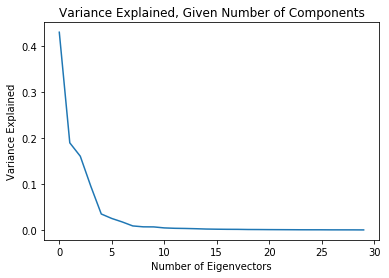

In [33]:
# Run PCA to help identify underlying traffic patterns per site

dfpca = StandardScaler().fit_transform(pivotpca)
fit = PCA()
pca = fit.fit_transform(dfpca)
plt.plot(fit.explained_variance_ratio_)
plt.title("Variance Explained, Given Number of Components")
plt.xlabel("Number of Eigenvectors")
plt.ylabel("Variance Explained")
k=4
print(fit.explained_variance_ratio_[:5])
print('{p}% of variance explained after {k} PCAs'.format(p=round(fit.explained_variance_ratio_[:k].sum()*100,1),k=k))

In [34]:
# Start building table from pca for plotting
dfpca = pd.DataFrame(pca[:, :4], index=pivotpca.index, columns=['pca1','pca2','pca3','pca4'])

# Append average hourly traffic per site
pivotavg = pd.pivot_table(df, values='hourly_counts', index='sensor_id', aggfunc=np.mean)
dfpca = dfpca.join(pivotavg, on='sensor_id')

# Append proportion of weekend traffic per site
pivotwkd = pd.pivot_table(df, values='hourly_counts', index='sensor_id', columns='day', aggfunc=np.mean)
pivotwkd['wkend_share'] = pivotwkd.iloc[:, -2:].sum(axis=1) / pivotwkd.iloc[:, :].sum(axis=1)
pivotwkd = pivotwkd['wkend_share']
dfpca = dfpca.join(pivotwkd, on='sensor_id')

# Append site names
dfpca = dfpca.join(names_table, on='sensor_id')
dfpca['sensor'] = (dfpca.index.map(lambda row: '0'+str(row)\
                                    if int(row)<10 else row)).astype('str')\
                                     + " : " + dfpca['sensor_name']

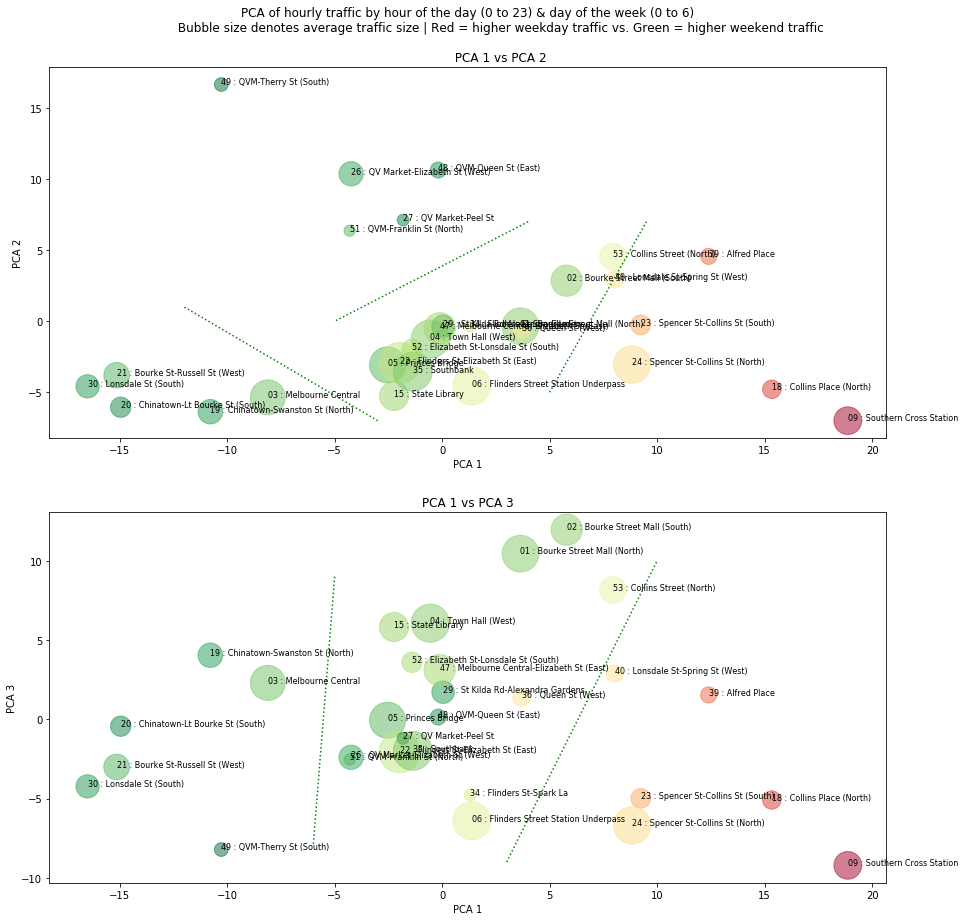

In [35]:
# Scatter plot to identify possible groupings of sites
fig, ax = plt.subplots(figsize=(15,15), ncols=1, nrows=2)
ax[0].set_title('PCA of hourly traffic by hour of the day (0 to 23) & day of the week (0 to 6)\n\
                 Bubble size denotes average traffic size | Red = higher weekday traffic vs. Green = higher weekend traffic\n\n\
                 PCA 1 vs PCA 2')
ax[1].set_title('PCA 1 vs PCA 3')

# Plot PCA 1 vs PCA 2
pcamap1 = ax[0].scatter(dfpca.pca1, dfpca.pca2, s=dfpca.hourly_counts,
                        c=dfpca.wkend_share, cmap='RdYlGn', alpha=0.5)
for i in range(len(dfpca.index)):
  ax[0].text(dfpca.iloc[i].pca1, dfpca.iloc[i].pca2, dfpca.iloc[i].sensor, fontsize=8)

# Plot PCA 1 vs PCA 3
pcamap2 = ax[1].scatter(dfpca.pca1, dfpca.pca3, s=dfpca.hourly_counts,
                        c=dfpca.wkend_share, cmap='RdYlGn', alpha=0.5)
for i in range(len(dfpca.index)):
  ax[1].text(dfpca.iloc[i].pca1, dfpca.iloc[i].pca3, dfpca.iloc[i].sensor, fontsize=8)

ax[0].set_xlabel('PCA 1')
ax[0].set_ylabel('PCA 2')
ax[1].set_xlabel('PCA 1')
ax[1].set_ylabel('PCA 3')
#fig.colorbar(pcamap1, orientation='horizontal', pad=0.05, shrink=0.3, ax=ax[1])

# Plot estimated grouping boundary for PCA 1 vs PCA 3
ax[0].plot((5,9.5), (-5,7), ls=':', c='g')
ax[0].plot((4,-5), (7,0), ls=':', c='g')
ax[0].plot((-3,-12), (-7,1), ls=':', c='g')

# Plot estimated grouping boundary for PCA 1 vs PCA 3
ax[1].plot((-5,-6), (9,-8), ls=':', c='g')
ax[1].plot((3,10), (-9,10), ls=':', c='g')

plt.show()

In [36]:
# # Visualize in 3D to get a full 3-way relationship
# import plotly.graph_objects as go
# fig = go.Figure(data=go.Scatter3d(x=dfpca.pca1, y=dfpca.pca2,z=dfpca.pca3,
#       text=dfpca.sensor, mode='markers', marker=dict(sizeref=20, size=dfpca.hourly_counts,
#       color = dfpca.wkend_share, colorscale = 'RdYlGn')))
# fig.update_layout(height=600, width=800, scene = dict(xaxis=dict(title='PCA 1'),
#                   yaxis=dict(title='PCA 2'), zaxis=dict(title='PCA 3')))
# fig.show()

In [37]:
# Identify number of groups
group_name = {1: 'Mixed-use sites',
              2: 'Business sites',
              3: 'Leisure sites'}

# Assign each site ID to a group
# in format {sensor_ID:group_name}
grouped_site = { 1:1,  2:1,  3:1,  4:1,  5:1,  6:1,  9:2, 15:1, 18:2, 19:1,
                20:1, 21:1, 22:1, 23:2, 24:2, 26:3, 27:3, 29:1, 30:1, 34:1,
                35:1, 36:1, 39:2, 40:2, 47:1, 48:3, 49:3, 51:3, 52:1, 53:1}

df['group'] = df['sensor_id'].map(grouped_site)

In [38]:
weekdays = [0,1,2,3,4]
weekends = [5,6]
groups   = [1,2,3]

# Prepare data to plot hourly variation by group:
hour_data_list = []
for days in [weekdays, weekends]:
  for group in groups:
    data = df[(df['day'].isin(days)) & (df['group']==group)]
    # For individual sites in that group:
    sites = pd.pivot_table(data, values='hourly_counts',
                           index='time', columns='sensor_id',
                           aggfunc=np.nanmean)
    cols = sites.columns
    sites = preprocessing.normalize(sites, norm='l1', axis=0)
    hour_data_sites = pd.DataFrame(sites, index=range(0,24), columns=cols)
    # For total sites in that group:
    total = pd.pivot_table(data, values='hourly_counts',
                           index='time',
                           aggfunc=np.nanmean)
    cols = ['all_sensors']
    total = preprocessing.normalize(total, norm='l1', axis=0)
    hour_data_total = pd.DataFrame(total, index=range(0,24), columns=cols)
    # Combine
    hour_data_list.append((hour_data_sites, hour_data_total, group, days))

# Prepare data to plot day of the week variation by group:
day_data_list = []
for group in groups:
    data = df[df['group']==group]
    # For individual sites in that group:
    sites = pd.pivot_table(data, values='hourly_counts',
                           index='day', columns='sensor_id',
                           aggfunc=np.nanmean)
    cols = sites.columns
    sites = preprocessing.normalize(sites, norm='l1', axis=0)
    day_data_sites = pd.DataFrame(sites, index=range(0,7), columns=cols)
    # For total sites in that group:
    total = pd.pivot_table(data, values='hourly_counts',
                           index='day',
                           aggfunc=np.nanmean)
    cols = ['all_sensors']
    total = preprocessing.normalize(total, norm='l1', axis=0)
    day_data_total = pd.DataFrame(total, index=range(0,7), columns=cols)
    # Combine
    day_data_list.append((day_data_sites, day_data_total, group))

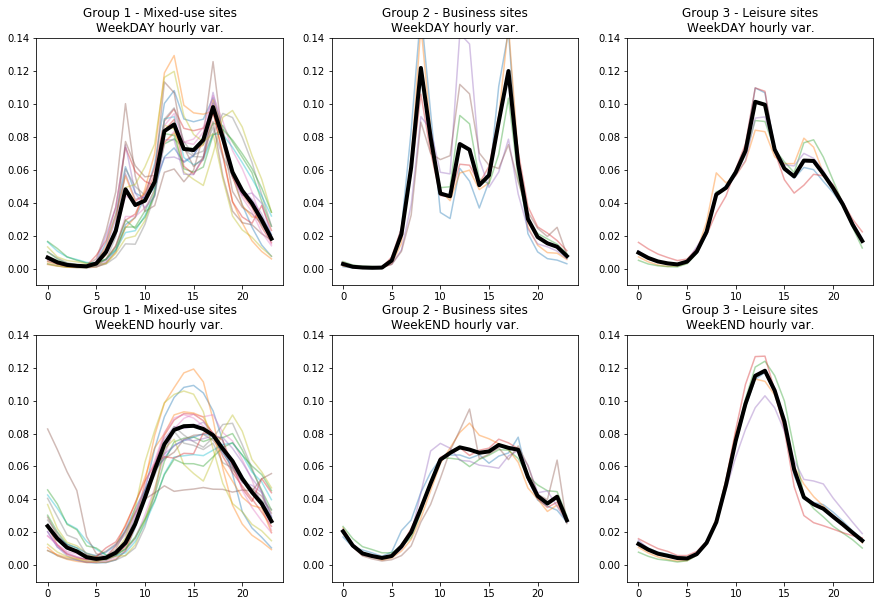

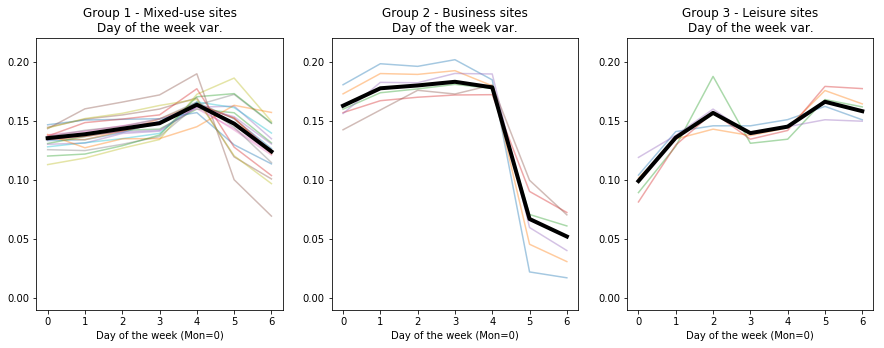

In [39]:
# Plot normalized hourly variation data
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(15,10))
for i, ax in zip(range(len(hour_data_list)), axes.flat):
    ax.plot(hour_data_list[i][0], alpha=0.4)
    ax.plot(hour_data_list[i][1], linewidth=4, c='black')    
    ax.set_ylim(-0.01,0.14)
    wkday = 'WeekDAY' if len(hour_data_list[i][3]) > 2 else 'WeekEND'
    grp = hour_data_list[i][2]
    ax.set_title('Group {g1} - {g2}\n{w} hourly var.'.format(g1=grp, g2=group_name[grp],w=wkday))

# Plot normalized day of the week variation data
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(15,5))
for i, ax in zip(range(len(day_data_list)), axes.flat):
    ax.plot(day_data_list[i][0], alpha=0.4)
    ax.plot(day_data_list[i][1], linewidth=4, c='black')    
    ax.set_ylim(-0.01,0.22)
    ax.set_xlabel('Day of the week (Mon=0)')
    grp = hour_data_list[i][2]
    ax.set_title('Group {g1} - {g2}\nDay of the week var.'.format(g1=grp, g2=group_name[grp]))
plt.show()

In [40]:
# Aggregate similar sites together using group mean
# to formulate models by group instead of by invidual site.
# Mean is chosen in order to give more weight to sites with higher traffic.

dfs = df.copy()
dfs = dfs[['date_time', 'hourly_counts', 'group']]
dfs = pd.pivot_table(dfs, values='hourly_counts', index='date_time',
                     columns='group', aggfunc=np.mean)
dfs = dfs + 1 # for log transform
dfs.head(3)

group,1,2,3
date_time,,,
2018-01-01 00:00:00,1614.947368,729.333333,326.8
2018-01-01 01:00:00,1692.105263,412.833333,244.2
2018-01-01 02:00:00,979.421053,229.666667,129.2


# SARIMA model

### Train-test split

In [41]:
# Set train/test time split
train_start  = pd.to_datetime('2018010100', format='%Y%m%d%H', errors='ignore')
train_end    = pd.to_datetime('2019103123', format='%Y%m%d%H', errors='ignore')
test_start   = pd.to_datetime('2019110100', format='%Y%m%d%H', errors='ignore')

sample_start = pd.to_datetime('2019080500', format='%Y%m%d%H', errors='ignore') # Mon midnight
sample_end   = sample_start + pd.Timedelta(days=7*3) - pd.Timedelta(hours=1)    # Sun 11pm + 3 wks
one_week = pd.Timedelta(hours=7*24)

# Assign train/test data frames
dfs_train = dfs.loc[:train_end]
dfs_test  = dfs.loc[test_start:]

### Data decomposition & stationarity

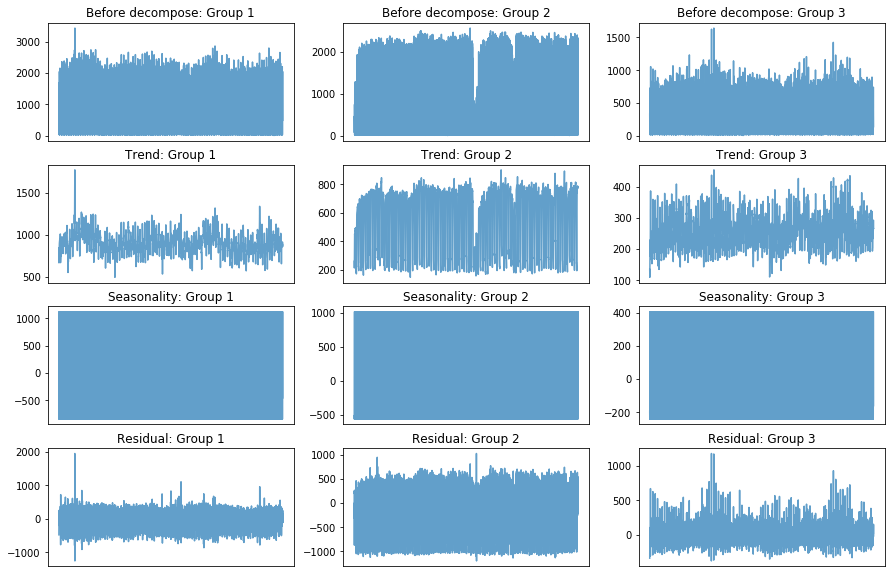

In [42]:
# Time series data composition per group
from statsmodels.tsa.seasonal import seasonal_decompose
groups = [1,2,3]
def decomp_list(dfs, groups):
  decomp, titles = [], []
  for group in groups:
    data = dfs_train[group]
    d    = seasonal_decompose(data,model='additive')
    decomp.append(data)
    titles.append('Before decompose: Group {g}'.format(g=group))
    decomp.append(d.trend)
    titles.append('Trend: Group {g}'.format(g=group))
    decomp.append(d.seasonal)
    titles.append('Seasonality: Group {g}'.format(g=group))
    decomp.append(d.resid)
    titles.append('Residual: Group {g}'.format(g=group))
  return decomp, titles

decomp, titles = decomp_list(dfs, groups)
order = {0:0, 1:4, 2:8, 3:1, 4:5, 5:9, 6:2, 7:6, 8:10, 9:3, 10:7, 11:11}
fig, axes = plt.subplots(ncols=3, nrows=4, figsize=(15,10))
for n, ax in zip(range(12), axes.flat):
  ax.plot(decomp[order[n]], alpha=0.7)
  ax.set_title(titles[order[n]], fontsize=12)
  ax.set_xticks([])
plt.show()

In [43]:
# TO BE REMOVED **********
# Analyse daily and weekly seasonal cycles for Group 1

# from statsmodels.tsa.seasonal import seasonal_decompose
# data   = dfs[1][sample_start:sample_end]
# daily  = seasonal_decompose(data, model='additive', freq=24)
# weekly = seasonal_decompose(data, model='additive', freq=24*7)
# adjusted = data - daily.seasonal - weekly.seasonal

# fig, axes = plt.subplots(ncols=1, nrows=4, figsize=(15,10))
# axes[0].plot(data)
# axes[1].plot(daily.seasonal)
# axes[2].plot(weekly.seasonal)
# axes[3].plot(adjusted)

# titles = ['Original', '24-period (daily) seasonal decompose',
#           '24x7-period (weekly) seasonal decompose', 'Original minus daily & weekly cycles']
# for title, ax in zip(titles, axes.flat):
#   ax.set_title(title)
#   ax.set_xticks([])
# plt.show()

In [44]:
# Calculate p-value of stationarity test over 2-year period

from statsmodels.tsa.stattools import adfuller
print('Verify stationarity using Dickey-Fuller test (p-value < 0.05):')
for group in groups:
  print('p-value for Group {g}: {af}'.format(g=group,af=adfuller(dfs_train[group])[1]))

Verify stationarity using Dickey-Fuller test (p-value < 0.05):
p-value for Group 1: 2.0061576484293606e-24
p-value for Group 2: 0.0
p-value for Group 3: 1.0497504651978425e-29


### Seasonal differencing

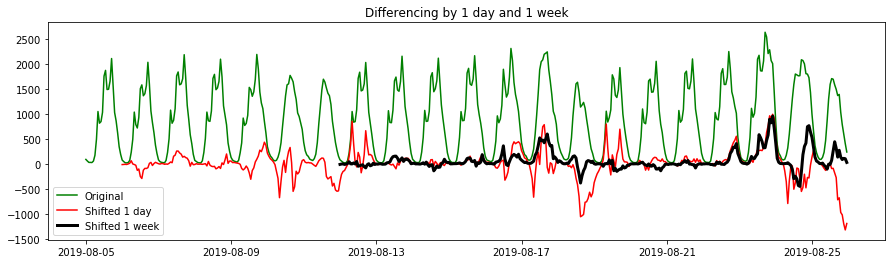

In [45]:
# Difference data by a day and by a week for Group 1
data = dfs[1][sample_start:sample_end]
data_shift_day  = data - data.shift(24)
data_shift_week = data - data.shift(24*7)
fig, ax = plt.subplots(figsize=(15,4))
plt.plot(data, c='green', label='Original')
plt.plot(data_shift_day,  c='red', label='Shifted 1 day')
plt.plot(data_shift_week, c='black', lw=3, label='Shifted 1 week')
ax.set_title('Differencing by 1 day and 1 week')
plt.legend()
plt.show()

### Autocorrelation (ACF) & Partial Autocorrelation (PACF)

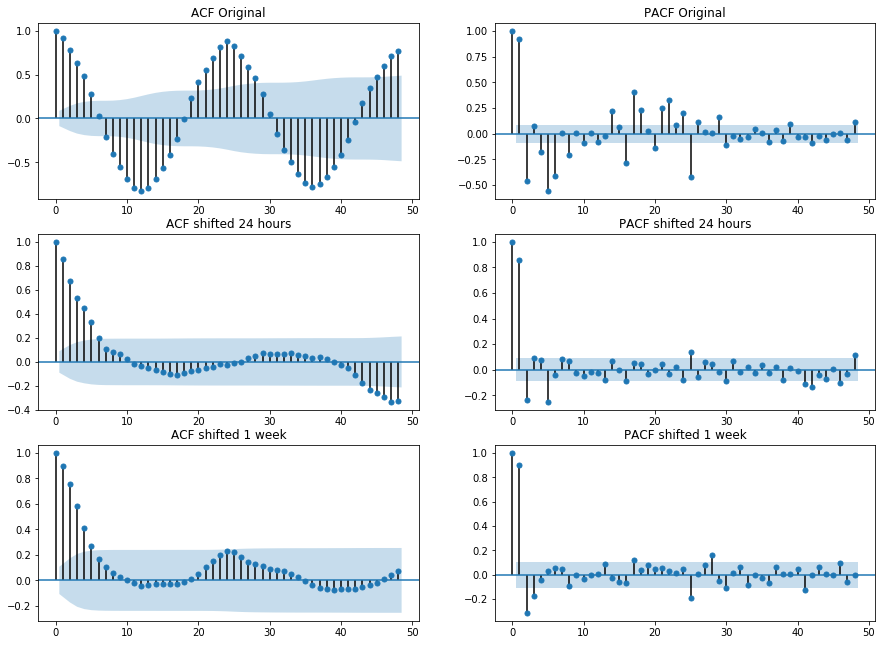

In [46]:
# Zoom in lags over 2 days
lags = 24*2

# Adjust time window since shifted data has null values at the start
data_shift_day_p  = data_shift_day[sample_start + pd.Timedelta(hours=24):]
data_shift_week_p = data_shift_week[sample_start + pd.Timedelta(hours=7*24):]

# Plot ACF & PCF
fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(15,11))
plot_acf (data, lags=lags, ax=axes.flat[0], title='ACF Original')
plot_pacf(data, lags=lags, ax=axes.flat[1], title='PACF Original')
plot_acf (data_shift_day_p, lags=lags, ax=axes.flat[2], title='ACF shifted 24 hours')
plot_pacf(data_shift_day_p, lags=lags, ax=axes.flat[3], title='PACF shifted 24 hours')
plot_acf (data_shift_week_p, lags=lags, ax=axes.flat[4], title='ACF shifted 1 week')
plot_pacf(data_shift_week_p, lags=lags, ax=axes.flat[5], title='PACF shifted 1 week');

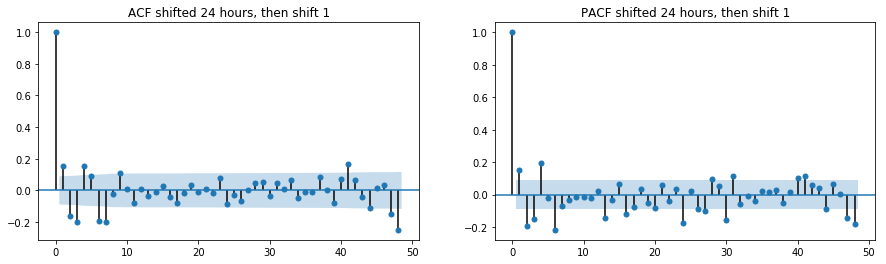

In [47]:
# Now shift the 24-hour shift by 1 since ACF is not decaying fast
data_shift_day1   = data_shift_day - data_shift_day.shift(1)
data_shift_day_p  = data_shift_day1[sample_start + pd.Timedelta(hours=24+1):]

# Replot ACF & PCF
fig, axes = plt.subplots(ncols=2, figsize=(15,4))
plot_acf (data_shift_day_p, lags=lags, ax=axes.flat[0], title='ACF shifted 24 hours, then shift 1')
plot_pacf(data_shift_day_p, lags=lags, ax=axes.flat[1], title='PACF shifted 24 hours, then shift 1');

In [48]:
# Determine baseline SARIMA parameters from the latest ACF & PACF
# (24-hour shift, then 1 more shift)

p = 6  # lag from PACF
d = 1  # non-seasonal differences taken to get stationarity
q = 7  # lag from ACF
m = 24 # cycle repeats after 24 hours
P = 2  # 2 if in PACF 24 & 48 are significant
D = 1  # follows d
Q = 2  # 2 if in ACF 24 & 48 are significant

### Run baseline SARIMA model

In [49]:
# # Select data
# num_of_wks = 2
# data_arima = dfs[1][sample_start : sample_start + one_week * num_of_wks]
# start = time.time()
# print(f'Start: {(datetime.utcfromtimestamp(start).strftime("%H:%M:%S"))}')

# # Run SARIMA model using parameters from baseline above
# model = SARIMAX(data_arima, order=(p, d, q),
#                 seasonal_order=(P, D, Q, m)).fit()
# print(f'End: {datetime.utcfromtimestamp(time.time()).strftime("%H:%M:%S")} in {round((time.time()-start)/60,1)} minutes')

# # Pickle summary results
# filename = 'saved_models/pickle_sarima_base.sav'
# pickle.dump(model.summary(), open(filename, 'wb'))

In [50]:
# Open pickled baseline after training
filename = 'saved_models/pickle_sarima_base.sav'
baseline = pickle.load(open(filename, 'rb'))
print(baseline)

                                 Statespace Model Results                                 
Dep. Variable:                                  1   No. Observations:                  505
Model:             SARIMAX(6, 1, 7)x(2, 1, 2, 24)   Log Likelihood               -2926.610
Date:                            Fri, 21 Feb 2020   AIC                           5889.220
Time:                                    23:29:55   BIC                           5964.348
Sample:                                08-05-2019   HQIC                          5918.751
                                     - 08-26-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0773      0.344     -0.225      0.822      -0.751       0.597
ar.L2         -0.1866      0.172   

In [51]:
# Hyperparameter list to test
p_list = [6,7,13,16,17,20,24]
q_list = [6,7,8,9,10]
P_list = [1,2]
Q_list = [1,2]
d, D, m = 1, 1, 24
num_of_wks = 2
print('No of combinations: {c}'.format(c=len(p_list) * len(q_list) * len(P_list) * len(Q_list)))

data_arima = dfs[1][sample_start : sample_start + one_week * num_of_wks]
sample_size = len(data_arima)
results = []

No of combinations: 140


In [52]:
# # Optimize hyperparameters for Group 1
# start = time.time()
# print(f'Start: {(datetime.utcfromtimestamp(start).strftime("%H:%M:%S"))}')

# # Iterate through hyperparam list to train SARIMA model
# for p in p_list:
#   for q in q_list:
#     try:
#       model = SARIMAX(data_arima, order=(p, d, q), seasonal_order=(P, D, Q, m)).fit()
#     except:
#       continue
#     aic = model.aic
#     if aic < 1e10: # if fail to converge
#       best_aic = aic
#     results.append([p, d, q, P, D, Q, m, sample_size, round(aic,1)])

#   result_table = pd.DataFrame(results)
#   result_table.columns = ['p','d','q','P','D','Q','m','samples','AIC']
#   result_table = result_table.sort_values(by='AIC', ascending=True).reset_index(drop=True)
  
# print(f'End: {datetime.utcfromtimestamp(time.time()).strftime("%H:%M:%S")} in {round((time.time()-start)/60,1)} minutes')

# # Save result table in pickle
# filename = 'saved_models/pickle_sarima_optimization.sav'
# pickle.dump(result_table, open(filename, 'wb'))

In [53]:
# Open hyperparameter list from pickle
filename = 'saved_models/pickle_sarima_optimization.sav'
sarima_hyperparams = pickle.load(open(filename, 'rb'))
print('Top 3 hyperparameters from grid search sorted by AIC:')
display(sarima_hyperparams[:3])

Top 3 hyperparameters from grid search sorted by AIC:


,p,d,q,P,D,Q,m,samples,AIC
0,7,1,6,2,1,2,24,337,3810.3
1,6,1,6,2,1,2,24,337,3812.0
2,6,1,8,2,1,2,24,337,3813.2


In [85]:
# # Run SARIMA model with optimized parameters

# p,d,q,P,D,Q,m = sarima_hyperparams.iloc[0][:7].astype(int)

# num_of_wks = 3
# data_arima = dfs[1][sample_start : sample_start + one_week * num_of_wks]
# model = SARIMAX(data_arima, order=(p, d, q), seasonal_order=(P, D, Q, m)).fit()
# # Pickle SARIMA trained model
# filename = 'saved_models/pickle_sarima.sav'
# pickle.dump(model, open(filename, 'wb'))

In [86]:
# Open pickled SARIMA after training
filename = 'saved_models/pickle_sarima.sav'
sarima = pickle.load(open(filename, 'rb'))
print(sarima.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                       1   No. Observations:                  505
Model:             SARIMAX(7, 1, 6)x(2, 1, [1, 2], 24)   Log Likelihood               -2925.238
Date:                                 Mon, 24 Feb 2020   AIC                           5886.475
Time:                                         14:23:00   BIC                           5961.603
Sample:                                     08-05-2019   HQIC                          5916.006
                                          - 08-26-2019                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2914      0.346     -0.843      0.399      -0.969       0

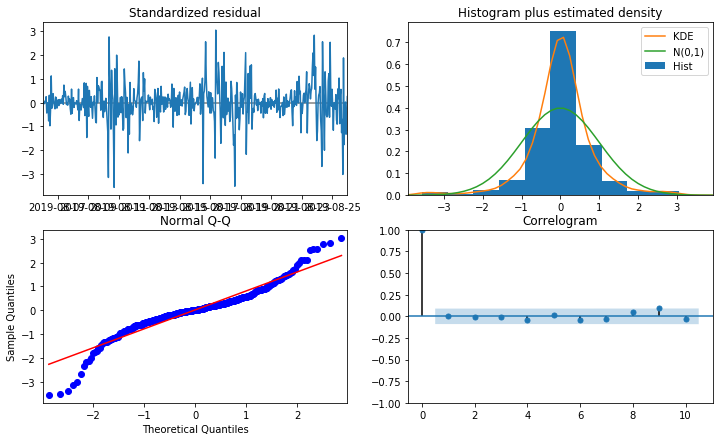

In [87]:
# Check assumptions of SARIMA model results
sarima.plot_diagnostics(figsize=(12,7));

In [88]:
# Assign periods for plotting
start      = sample_start + one_week * 2
sample_end = start + one_week
test_start = sample_end
test_end   = test_start   + one_week

data_train = dfs[1][start : sample_end]
data_test  = dfs[1][test_start : test_end]

# Generate prediction and confidence interval
pred = sarima.predict(start=test_start, end=test_end, dynamic=True)
pred_conf = sarima.get_forecast(168).conf_int()

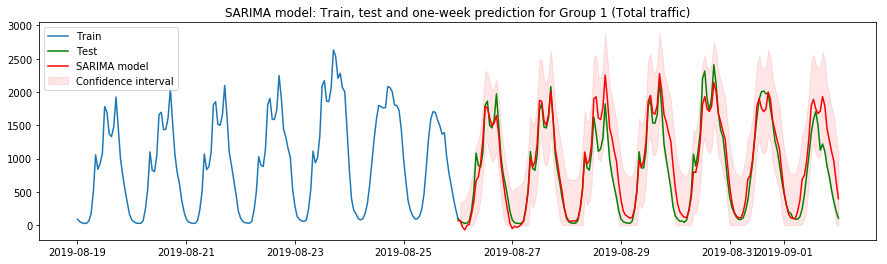

In [101]:
# Visualize train, test and prediction

fig, ax = plt.subplots(figsize=(15,4))
plt.plot(data_train, label='Train')
plt.plot(data_test, label='Test', c='g')
plt.plot(pred, label='SARIMA model', c='r')
plt.fill_between(pred_conf.index, pred_conf['upper 1'],
                 pred_conf['lower 1'].clip(0), color='r', alpha=.1,
                 label='Confidence interval');
plt.legend(loc='upper left')
ax.set_title('SARIMA model: Train, test and one-week prediction for Group 1 (Total traffic)')
plt.show()

In [ ]:
# CALCULATE MSE FOR TEST PERIODS

# Neural network - LSTM

### Train/test split

In [141]:
# Set train/test time split
train_start  = pd.to_datetime('2018010100', format='%Y%m%d%H', errors='ignore') 
train_end    = pd.to_datetime('2019083123', format='%Y%m%d%H', errors='ignore')
test_start   = train_end  + pd.Timedelta(hours=1)
test_end     = pd.to_datetime('2020013123', format='%Y%m%d%H', errors='ignore')

# Assign train/test data frames
dfn = dfs.copy()
dfn_train = dfn.loc[train_start:train_end]
dfn_test  = dfn.loc[test_start:]
print('Test/train ratio: {r}'.format(r=round(len(dfn_test)/(len(dfn_train)+len(dfn_test)),2)))

Test/train ratio: 0.2


### Scale and assign to groups

In [142]:
# Scale and assign each group separately
scaler = MinMaxScaler()
# Group 1
scaler.fit(np.array(dfn_train[1]).reshape(-1,1))
df1_train = (scaler.transform(np.array(dfn_train[1]).reshape(-1,1))).ravel()
df1_test  = (scaler.transform(np.array(dfn_test[1]).reshape(-1,1))).ravel()
# Group 2
scaler.fit(np.array(dfn_train[2]).reshape(-1,1))
df2_train = (scaler.transform(np.array(dfn_train[2]).reshape(-1,1))).ravel()
df2_test  = (scaler.transform(np.array(dfn_test[2]).reshape(-1,1))).ravel()
# Group 2
scaler.fit(np.array(dfn_train[3]).reshape(-1,1))
df3_train = (scaler.transform(np.array(dfn_train[3]).reshape(-1,1))).ravel()
df3_test  = (scaler.transform(np.array(dfn_test[3]).reshape(-1,1))).ravel()
# Show train & test sample
display(df1_train.shape, df1_test.shape)

(14592,)

(3672,)

### Set up and compile neural network

In [143]:
# Function to split time series data into:
#   n consecutive time steps of data as X
#   and 1 time step of data as y

import numpy as np
def split_data(data, n_steps):
    X, y = list(), list()
    for i in range(len(data)):
        # index of last element for each grouping of steps
        end_ix = i + n_steps
    # break condition at the end of the sequence
        if end_ix > len(data)-1:
            break
        # X = first n elements, y = the element after
        seq_x, seq_y = data[i:end_ix], data[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [144]:
import warnings
warnings.filterwarnings("ignore")

In [156]:
# Assign number of time steps & epochs
# n_steps = n sequence of X in time series followed by one Y
n_steps    = 24*7*4
batch_size = 24*7
epochs     = 10
n_features = 1

# Reshape X from [samples, steps] into [samples, steps, features]
# as the required Keras input format
X_train, y_train = split_data(df1_train, n_steps)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_test, y_test = split_data(df1_test, n_steps)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

# Assign hyperparameters for model
cells1 = 64
cells2 = 64
activ1 = 'relu'
activ2 = 'relu'
optimizer='adam'
loss='mse'
metrics=['mse', 'mae', 'mape', 'cosine']

# Define and fit model
model = Sequential()
model.add(LSTM(cells1, activation=activ1,
               input_shape=(n_steps, n_features),
               return_sequences=True))
model.add(LSTM(cells1, activation=activ1,
               return_sequences=True))
model.add(LSTM(cells1, activation=activ1,
               return_sequences=True))
model.add(LSTM(cells2, activation=activ2))
model.add(Dense(1))
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
baseline = model.fit(X_train, y_train, epochs=epochs,
                     batch_size=batch_size, verbose=1,
                     validation_data=(X_test, y_test))

Train on 13920 samples, validate on 3000 samples
Epoch 1/10
13920/13920 [==============================] - 199s 14ms/step - loss: 0.0480 - mse: 0.0480 - mae: 0.1855 - mape: 43119.3789 - cosine: 0.9926 - val_loss: 0.0371 - val_mse: 0.0371 - val_mae: 0.1686 - val_mape: 958.0410 - val_cosine: 0.9993
Epoch 2/10
13920/13920 [==============================] - 196s 14ms/step - loss: 0.0158 - mse: 0.0158 - mae: 0.0949 - mape: 25285.3652 - cosine: 0.9978 - val_loss: 0.0071 - val_mse: 0.0071 - val_mae: 0.0619 - val_mape: 143.6330 - val_cosine: 0.9947
Epoch 3/10
13920/13920 [==============================] - 196s 14ms/step - loss: 0.0066 - mse: 0.0066 - mae: 0.0586 - mape: 7125.8423 - cosine: 0.9535 - val_loss: 0.0061 - val_mse: 0.0061 - val_mae: 0.0570 - val_mape: 117.8542 - val_cosine: 0.9973
Epoch 4/10
13920/13920 [==============================] - 192s 14ms/step - loss: 0.0060 - mse: 0.0060 - mae: 0.0562 - mape: 1913.1851 - cosine: 0.9221 - val_loss: 0.0059 - val_mse: 0.0059 - val_mae: 0.0540

In [157]:
# # Pickle results
# filename = 'saved_models/pickle_lstm_base.sav'
# pickle.dump(baseline, open(filename, 'wb'))

In [161]:
# Open baseline from pickle
filename = 'saved_models/pickle_lstm_base.sav'
baseline = pickle.load(open(filename, 'rb'))

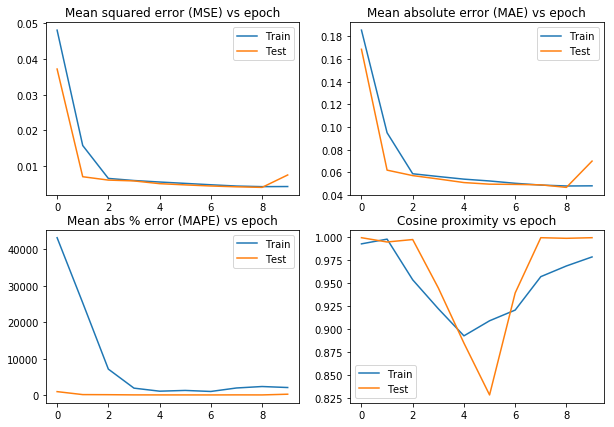

In [170]:
# Plot metrics vs num of epochs
metrics=['mse', 'mae', 'mape', 'cosine']
titles=['Mean squared error (MSE) vs epoch', 'Mean absolute error (MAE) vs epoch',
         'Mean abs % error (MAPE) vs epoch', 'Cosine proximity vs epoch']

fig, axes = plt.subplots(2,2, figsize=(10,7))
for i, ax in zip(range(len(metrics)), axes.flat):
    ax.plot(baseline.history[metrics[i]], label='Train')
    ax.plot(baseline.history['val_{metrics}'.format(metrics=metrics[i])], label='Test')
    ax.set_title(titles[i])
    ax.legend()
plt.show()

In [172]:
# Predict n steps
x_input = df1_test[:n_steps]
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[0.1081671]]


In [174]:
# Predict all in Test set
model.predict(X_test, verbose=0)

array([[0.10816707],
       [0.08255696],
       [0.06842609],
       ...,
       [0.27554882],
       [0.21679528],
       [0.16938218]], dtype=float32)

# To do list

~~EDA~~
1. ~~Narrow down sites and period~~
2. ~~Variation by high/low traffic sites~~
3. ~~Variation by hour / day of week / seasons~~

~~Cleansing~~
1. ~~Verify no missing timestamp~~
2. ~~Fill nulls based on general variation rule~~

~~Assign sites to groups~~
1. ~~Run PCA to get better insight on possible groupings~~
2. ~~Combine PCA with EDA info to decide on groupings~~
3. ~~Drop more sites if needed / restate outliers if needed~~

~~Stinky model - SARIMA~~
1. ~~Train/test split~~
2. ~~Stationarity~~
3. ~~Differencing~~
4. ~~PACF, ACF~~
5. ~~Select p, d, q~~
6. ~~Select P, D, Q, m seasonality~~
7. ~~Hyperparameters grid search~~
8. ~~Plot predicted periods~~ 

Enhanced model - LSTM
1. ~~Train/test split~~
2. ~~Set up a working LSTM network~~
2. Baseline Group 1
3. Hyperparameters grid search
5. Repeat for Groups 2 & 3

Visualisation for end users
1. Static heatmap on city centre map
2. Variable heatmap animation
3. Variable hourly plot animation
4. Web app
